# Introduction #

In this tutorial, we're going to walk you through some basic concepts in working with geospatial data and crop classification problem. This will help you to gain a better understanding about satellite imagery and vector data which we've provided for this event.

## Crop Classification ##

In this hackathon, you have to use ML model to identify which crop type is planted on all fields in the dataset in the year of 2021 using Sentinel-2 satellite images. 

## Crop Classification as a Machine Learning Problem ##

To solve crop classification using Machine Learning, the first thing you need to do is formulate crop classification into Machine Learning problem. One of the most commonly used approach(especially when you use deep learning models) is to look at crop classification as an image segmentation problem where you assign a class to each pixel of the image within the area of interest. Each class represents a specific crop type in the problem statement. However, there is no single right answer, you can choose the method the you feel most appropriate. Once you finalize the approach you want to use, you can start preparing the data for training your model.

### Data ###

The dataset you've received contains 2 formats of data: <i>raster</i> and <i>vector</i>.

#### Raster ####

Raster data is an image taken from Sentinel-2 satellite in the period between 2020 to 2021 over the study area where the image is taken approximate every 5 days. For each date, there are 12 images taken, each image represents the measurements that Sentinel-2 receives from the earth surface using different types of sensors. Unlike normal image which only has pixel intensities, satellite imagery also provides location information about the scene so that you can identify which area each pixel locates on earth.

Data in these images is going to be used as the input of our ML model.

![Raster data](sample_raster.png)

#### Vector ####
Vector data contains information about farm boundaries which will help you to locate farms on the satellite image so that you can pick relevant region to extract features from them. Each farm in training data will have a `crop_type` column attach to it, this column indicates the type of plants that is grew in that farm so that you can use them to training and optimizing your ML model. (<i><b>Note</b>: For test set, we only provide farm boundary data. Your job is to use the model you've built to predict the crop type of all fields.</i>)

![Vector data](sample_vector.png)

To work with geospatial data in Python, there are 2 libraries that are very handy: [`rasterio`](https://rasterio.readthedocs.io/en/latest/index.html) and [`geopandas`](https://geopandas.org/en/stable/index.html). `Rasterio` provides functions to manipulate the satellite image files and vector data while `Geopandas` makes dealing with the ground data become much easier. The code below shows how you can use these 2 libraries to explore and manipulate the data.


Dataset profile : {'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': 0.0, 'width': 2051, 'height': 2051, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(10.0, 0.0, 754360.0,
       0.0, -10.0, 1688690.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


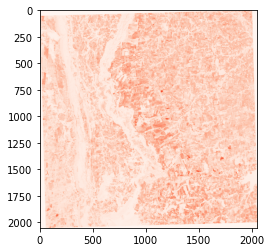

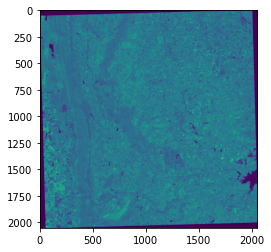

In [8]:
# Working with raster data
import rasterio
import matplotlib.pyplot as plt

# Open image files
R_dataset = rasterio.open('data/raw/image/20210101/IMG_DATA/47PQS_20210101_B04.jp2')
NIR_dataset = rasterio.open('data/raw/image/20210101/IMG_DATA/47PQS_20210101_B08.jp2')
print(f'Dataset profile : {R_dataset.profile}') # `profile` contains metadata about an image such as dimension, number of channels, and co-ordinate reference system 

# Read image data from dataset
R = R_dataset.read()[0]       # Read raster data from dataset, the array size will be equal to dimension in the dataset profile
NIR = NIR_dataset.read()[0]

plt.figure()
plt.imshow(R, cmap='Reds')
plt.figure()
plt.imshow(NIR)

Training Data
  years crop_type                                           geometry
0  2021         1  POLYGON ((101.55476 15.10233, 101.55479 15.103...
1  2021         1  POLYGON ((101.54317 15.09377, 101.54337 15.094...
2  2021         1  POLYGON ((101.52758 15.12749, 101.52815 15.129...
3  2021         3  POLYGON ((101.52441 15.12918, 101.52553 15.129...
4  2021         2  POLYGON ((101.45462 15.16983, 101.45582 15.169...
---------------------------------------------------------------------------------
Testing Data
  years                                           geometry
0  2021  POLYGON ((101.39646 15.23133, 101.39650 15.232...
1  2021  POLYGON ((101.49150 15.14814, 101.49229 15.148...
2  2021  POLYGON ((101.53370 15.22342, 101.53375 15.222...
3  2021  POLYGON ((101.54353 15.21618, 101.54479 15.216...
4  2021  POLYGON ((101.53824 15.09639, 101.53834 15.097...
---------------------------------------------------------------------------------
           geometry
crop_type          
1

<AxesSubplot:>

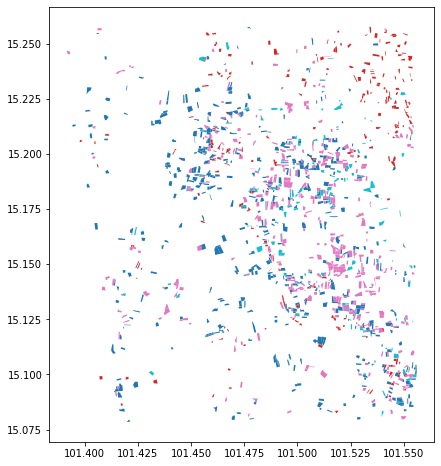

In [23]:
# Working with vector data
import geopandas

ground_truth = geopandas.read_file('data/shape/training_area/train_data.shp')
print('Training Data')
print(ground_truth.head())
print('---------------------------------------------------------------------------------')

print('Testing Data')
test_ground_truth = geopandas.read_file('data/shape/testing_area/test_data.shp')
print(test_ground_truth.head())
print('---------------------------------------------------------------------------------')

print(ground_truth[['crop_type', 'geometry']].groupby(['crop_type']).count()) # Compute class distribution

# Visulize ground data
ground_truth.plot(column='crop_type', figsize=(8,8))

### Convert vector to raster. ##


One usecase that occurs frequently when you work with geospatial data is vector-to-raster conversion. If this occur to your team, you can use `rasterio` and `geopandas` to convert vector data into image using.

`rasterio.features` package provides the `rasterize` method that turn vectors into an image with specific dimension and co-ordinate reference system. All you need to do is to pass in the list of tuple containing a polygon and value associated to it along with the transformation matrix of the resulting image. The code below show you how to do it.

Class pixel count: {1: 100162, 2: 29069, 3: 84342, 4: 23309}


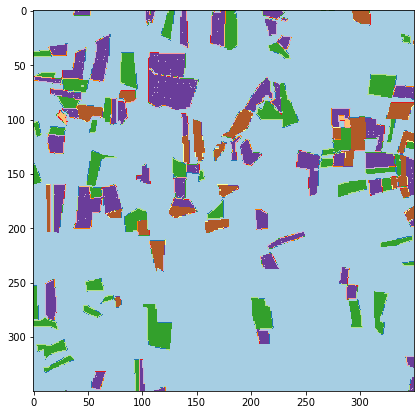

In [46]:
from rasterio.features import rasterize

img_profile = rasterio.open('data/raw/image/20210101/IMG_DATA/47PQS_20210101_B04.jp2').profile
label = geopandas.read_file('data/raw/shape/training_area/train_data.shp').to_crs(img_profile['crs'])
target_image = rasterize(
    shapes=[(row.geometry, int(row.crop_type)) for i, row in label.iterrows()], # Construct polygon and value tuples
    out_shape=(img_profile['width'], img_profile['height']),
    transform=img_profile['transform']                                          # This will make every pixel in the target image align correctly with satellite image
)
classes, pixel_counts = np.unique(target_image, return_counts=True)
print('Class pixel count: ' + str(dict(zip(classes[1:], pixel_counts[1:]))))
plt.figure(figsize=(7,7))
plt.imshow(target_image[750:1100, 1250:1600], cmap='Paired')